In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.preprocessing import MinMaxScaler

import gc
gc.enable()

In [2]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

This notebook focuses on pretraining the models using a different dataset for each model

## Load data

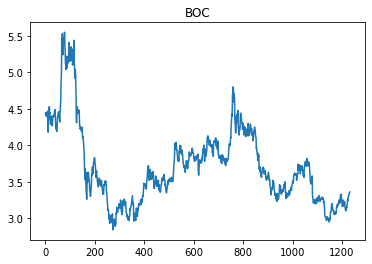

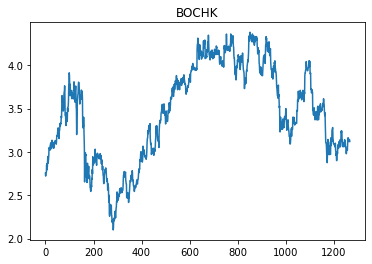

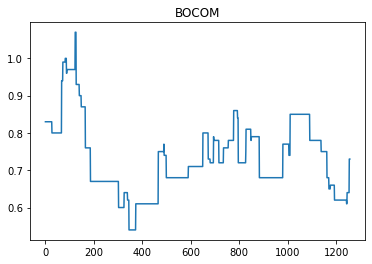

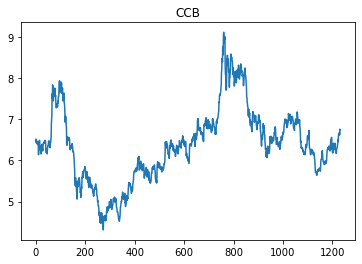

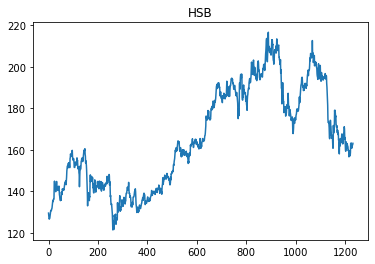

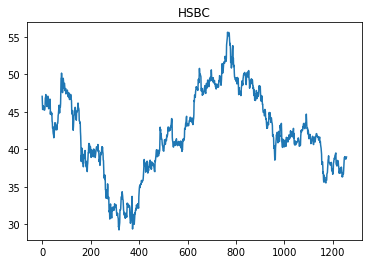

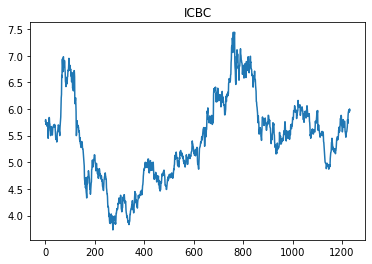

<Figure size 432x288 with 0 Axes>

In [4]:
G1 = ["BOC", "BOCHK", "BOCOM", "CCB", "HSB", "HSBC", "ICBC"]
data = {}

for corp in G1:
    df = pd.read_csv("Data/" + corp + ".csv")
    
    plt.plot(df.Close)
    plt.title(corp)
    plt.show()
    plt.clf()
    
    data[corp] = df.Close.to_numpy().reshape(-1,1)

The target dataset is used to test the models

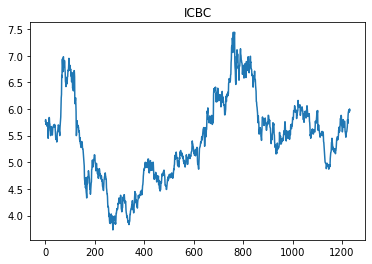

<Figure size 432x288 with 0 Axes>

In [5]:
df_tgt = pd.read_csv("Data/ICBC.csv")
    
plt.plot(df_tgt.Close)
plt.title("ICBC")
plt.show()
plt.clf()
    
target = df_tgt.Close.to_numpy().reshape(-1,1)

### Data preprocessing

In [6]:
def sliding_window(dataset, l, p, scaler, device):
    x, y = [], []

    for i in range(len(dataset)-l-p+1):
        #Get input of size l, starting from index i
        _x = dataset[i: i+l, :]
        _x = scaler.transform(_x)

        #Get the next p values as label
        _y = dataset[i+l: i+l+p, 0].reshape(-1,1)
        _y = scaler.transform(_y)

        x.append(_x)
        y.append(_y)

    x = np.array(x)
    y = np.array(y)
    
    x = torch.tensor(x).to(dtype=torch.float32).to(device)
    y = torch.tensor(y).to(dtype=torch.float32).to(device)

    return (x, y)

In [7]:
def reverse_normalize(x, scaler):
    x = x.reshape(-1,1).to('cpu')
    x = scaler.inverse_transform(x)
    
    x = torch.tensor(x).to(dtype=torch.float32)
    return x

In [8]:
def prepare_dataset(df, l, p, device):
    # 60-20-20 split
    training_ind = int(len(df)*0.6)
    validating_ind = int(len(df)*0.8)

    training_set = df[:training_ind]
    validation_set = df[training_ind:validating_ind]
    test_set = df[validating_ind:]
    
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaler.fit(training_set)
    
    trainX, trainY = sliding_window(training_set, l, p, scaler, device)
    valX, valY = sliding_window(validation_set, l, p, scaler, device)
    testX, testY = sliding_window(test_set, l, p, scaler, device)

    return trainX, trainY, valX, valY, testX, testY, scaler

# Train models

In [9]:
class MLP(nn.Module):

    def __init__(self, l=22, p=1):
        super(MLP, self).__init__()
        
        self.l = l
        self.p = p

        self.l1 = nn.Linear(l, 128)
        self.l2 = nn.Linear(128, 64)
        self.l3 = nn.Linear(64, 16)
        
        self.output = nn.Linear(16, p)
        

    def forward(self, x):
        batch_size = x.size(0)
        x = x.reshape(-1, self.l)
        
        x = self.l1(x)
        x = F.relu(x)
        
        x = self.l2(x)
        x = F.relu(x)
        
        x = self.l3(x)
        x = F.relu(x)
        
        x = self.output(x)

        return x.reshape(batch_size, -1, self.p)

In [10]:
class LSTM(nn.Module):

    def __init__(self, l=22, p=1):
        super(LSTM, self).__init__()
        
        self.l = l
        self.p = p

        self.l1 = nn.LSTM(l, 128, batch_first=True)
        self.l2 = nn.LSTM(128, 64, batch_first=True)
        self.l3 = nn.Linear(64, 16)
        self.output = nn.Linear(16, p)
        

    def forward(self, x):
        batch_size = x.size(0)
        x = x.reshape(batch_size, -1, self.l)
        
        x, _ = self.l1(x)
        x, _ = self.l2(x)
        
        x = self.l3(x)
        x = F.relu(x)
        
        x = self.output(x[:,-1,:])

        return x.reshape(batch_size, -1, self.p)

In [11]:
# Loss and indicator functions
def MAPE(x, y):
    return torch.mean(torch.abs((y - x) / y)) 

def RMSE(x, y):
    criterion = nn.MSELoss()
    return torch.sqrt(criterion(x, y))

def R2(x, y):
    target_mean = torch.mean(y)
    ss_tot = torch.sum((y - target_mean) ** 2)
    ss_res = torch.sum((y - x) ** 2)
    
    r2 = 1 - ss_res / ss_tot
    
    return r2

def indicator(x, y, scaler):
    x = reverse_normalize(x, scaler)
    y = reverse_normalize(y, scaler)
    
    mape = MAPE(x, y).item()
    rmse = RMSE(x, y).item()
    r2 = R2(x, y).item()
    
    return mape, rmse, r2

In [12]:
def build_model(MODEL):
    net = MODEL(l, p)

    if torch.cuda.is_available():
        net.cuda()

    optimizer = torch.optim.Adam(net.parameters(), lr=0.005)

    print(net)
    
    return net, optimizer

In [13]:
def train_model(net, optimizer, criterion, epochs, trainX, trainY, valX, valY, scaler):
    mse_train = np.zeros(epochs)
    mse_val = np.zeros(epochs)

    mape_train = np.zeros(epochs)
    mape_val = np.zeros(epochs)

    rmse_train = np.zeros(epochs)
    rmse_val = np.zeros(epochs)

    r2_train = np.zeros(epochs)
    r2_val = np.zeros(epochs)

    for epoch in range(epochs):    
        optimizer.zero_grad()

        pred = net(trainX)

        loss = criterion(pred, trainY)

        loss.backward()
        optimizer.step()

        mse_train[epoch] = loss.item()

        results = indicator(pred.detach(), trainY, scaler)
        mape_train[epoch] = results[0]
        rmse_train[epoch] = results[1]
        r2_train[epoch] = results[2]

        if epoch == 0 or (epoch + 1) % 100 == 0:
            print(f'epoch: {epoch+1:3}')
            print(f'loss: {loss.item():10.8f}')

        with torch.no_grad():
            val_pred = net(valX)

            error = criterion(val_pred, valY)

            if epoch == 0 or (epoch + 1) % 100 == 0:
                print(f'validation loss: {error.item():10.8f}')

            mse_val[epoch] = error.item()

            results = indicator(val_pred.detach(), valY, scaler)
            mape_val[epoch] = results[0]
            rmse_val[epoch] = results[1]
            r2_val[epoch] = results[2]
            
    return mse_train, mse_val, mape_train, mape_val, rmse_train, rmse_val, r2_train, r2_val

In [14]:
def visualize_result(train, val, name):
    epoch = range(1, len(train)+1)

    plt.plot(epoch, train, label='Training')
    plt.plot(epoch, val, label='Validating')

    plt.title(name)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
    plt.clf()

In [15]:
def test_model(net, criterion, testX, testY, scaler):
    net.eval()
    pred = net(testX)
    
    loss = criterion(pred, testY).item()
    print(f'MSE: {loss:10.8f}')
    
    results = indicator(pred.detach(), testY, scaler)
    
    print(f'MAPE: {results[0]:10.8f}')
    print(f'RMSE: {results[1]:10.8f}')
    print(f'R2: {results[2]:10.8f}')

    label = reverse_normalize(testY, scaler).numpy().flatten()
    pred = reverse_normalize(pred.detach(), scaler).numpy().flatten()

    plt.plot(range(len(label)), label, label='Ground truth')
    plt.plot(range(len(label)), pred, label='Prediction')

    plt.title('Test')
    plt.xlabel('Session')
    plt.ylabel('Close')
    plt.legend()

    plt.show()
    
    return [loss] + list(results)

In [16]:
criterion = nn.MSELoss()

In [17]:
def build_and_train(df, l, p, MODEL, criterion, epochs, X, Y, device):
    trainX, trainY, valX, valY, testX, testY, scaler = prepare_dataset(df, l, p, device)
    net, optimizer = build_model(MODEL)
    
    mse_train, mse_val, mape_train, mape_val, rmse_train, rmse_val, r2_train, r2_val = train_model(net, optimizer, criterion, epochs, trainX, trainY, valX, valY, scaler)
    
    visualize_result(mse_train, mse_val, "MSE")
    visualize_result(mape_train, mape_val, "MAPE")
    visualize_result(rmse_train, rmse_val, "RMSE")
    visualize_result(r2_train, r2_val, "R2")

    test_results = test_model(net, criterion, testX, testY, scaler)
    target_results = test_model(net, criterion, X, Y, scaler)
    
    return net, target_results

In [18]:
epochs = 300
l = 22
p = 1

In [19]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(target)
scaled_target = scaler.transform(target)

X, Y = sliding_window(target, l, p, scaler, device)

In [20]:
mlp_results = {}
lstm_results = {}

BOC
MLP(
  (l1): Linear(in_features=22, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=64, bias=True)
  (l3): Linear(in_features=64, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=1, bias=True)
)
epoch:   1
loss: 0.22777654
validation loss: 0.10361168
epoch: 100
loss: 0.00279804
validation loss: 0.00340121
epoch: 200
loss: 0.00180978
validation loss: 0.00265065
epoch: 300
loss: 0.00155677
validation loss: 0.00305589


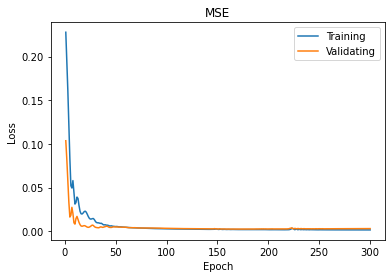

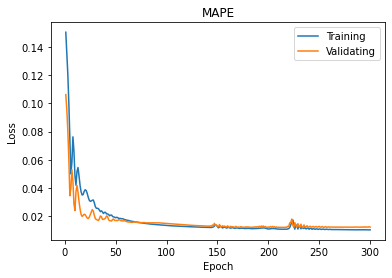

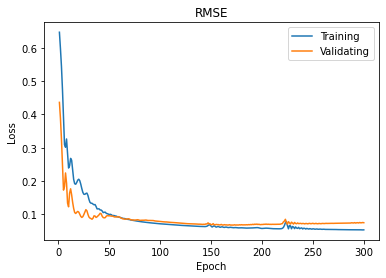

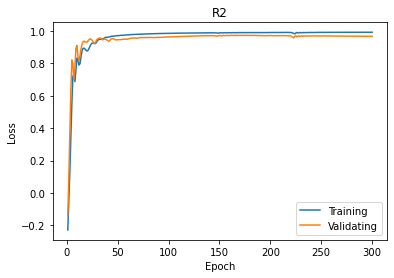

MSE: 0.00084080
MAPE: 0.00811158
RMSE: 0.03929044
R2: 0.97425318


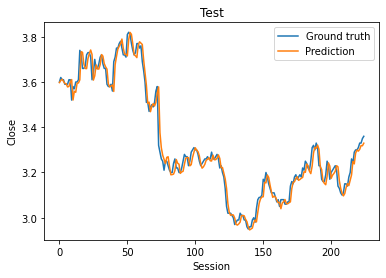

MSE: 0.00269506
MAPE: 0.01266193
RMSE: 0.07034338
R2: 0.98504490


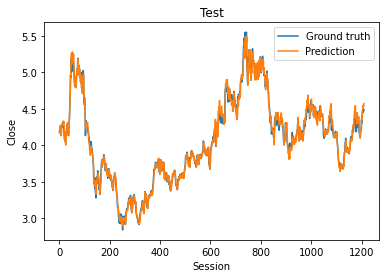

LSTM(
  (l1): LSTM(22, 128, batch_first=True)
  (l2): LSTM(128, 64, batch_first=True)
  (l3): Linear(in_features=64, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=1, bias=True)
)
epoch:   1
loss: 0.30776739
validation loss: 0.18230055
epoch: 100
loss: 0.00326936
validation loss: 0.00442397
epoch: 200
loss: 0.00207737
validation loss: 0.00242289
epoch: 300
loss: 0.00177880
validation loss: 0.00223225


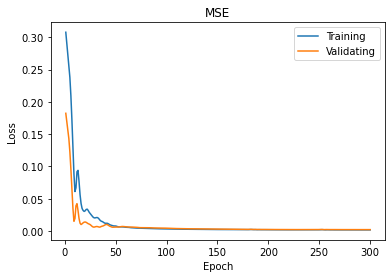

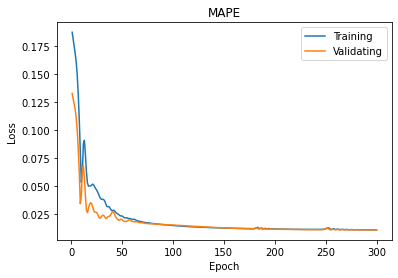

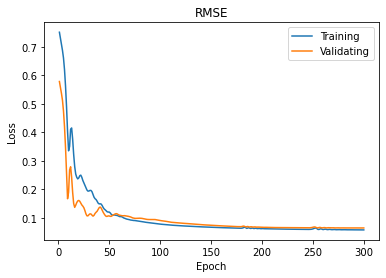

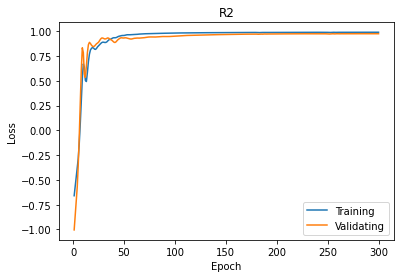

MSE: 0.00081358
MAPE: 0.00786189
RMSE: 0.03864910
R2: 0.97508681


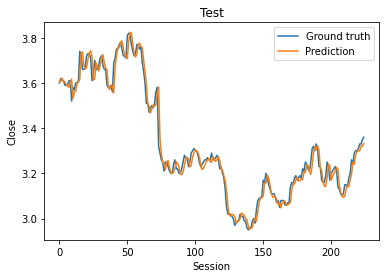

MSE: 0.00253805
MAPE: 0.01222907
RMSE: 0.06826359
R2: 0.98591614


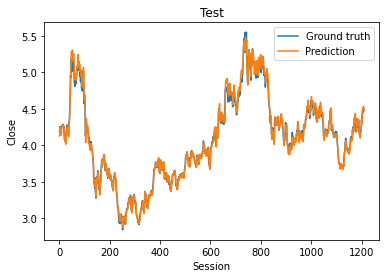

Models saved.
BOCHK
MLP(
  (l1): Linear(in_features=22, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=64, bias=True)
  (l3): Linear(in_features=64, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=1, bias=True)
)
epoch:   1
loss: 0.34891629
validation loss: 0.68934518
epoch: 100
loss: 0.00329444
validation loss: 0.00498721
epoch: 200
loss: 0.00225544
validation loss: 0.00353783
epoch: 300
loss: 0.00198282
validation loss: 0.00368994


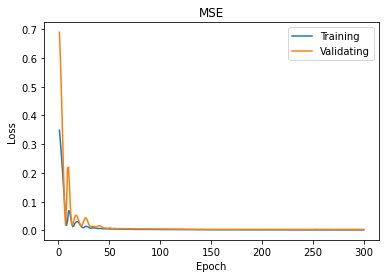

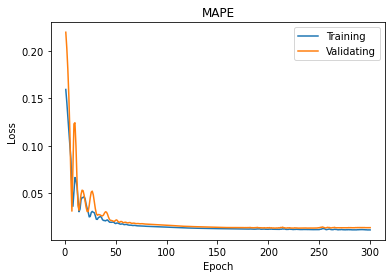

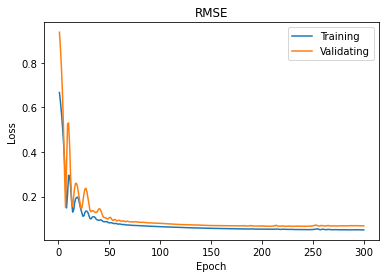

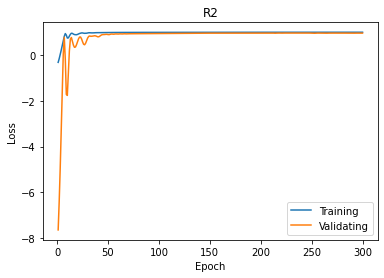

MSE: 0.00297530
MAPE: 0.01362920
RMSE: 0.06161004
R2: 0.95968950


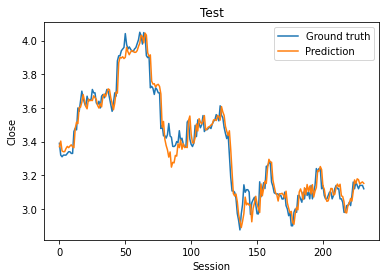

MSE: 0.00277036
MAPE: 0.01360976
RMSE: 0.05945035
R2: 0.98462701


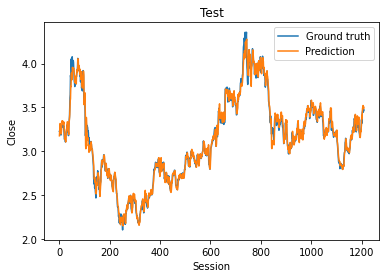

LSTM(
  (l1): LSTM(22, 128, batch_first=True)
  (l2): LSTM(128, 64, batch_first=True)
  (l3): Linear(in_features=64, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=1, bias=True)
)
epoch:   1
loss: 0.35964206
validation loss: 0.71570599
epoch: 100
loss: 0.00485078
validation loss: 0.00744180
epoch: 200
loss: 0.00289859
validation loss: 0.00327951
epoch: 300
loss: 0.00247038
validation loss: 0.00295649


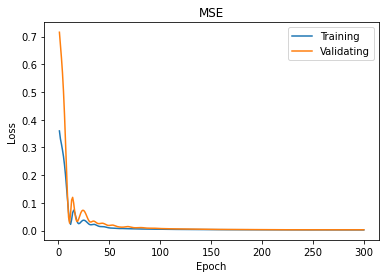

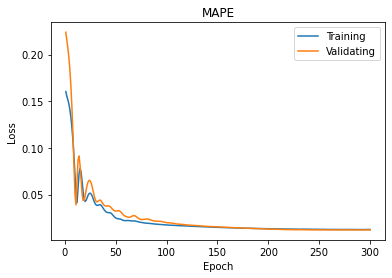

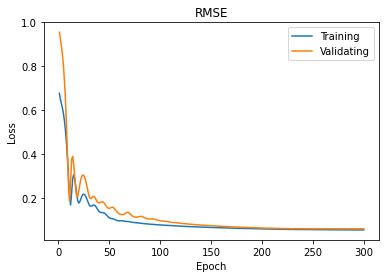

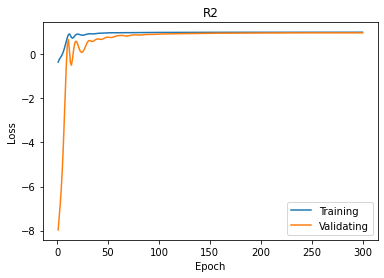

MSE: 0.00253394
MAPE: 0.01222755
RMSE: 0.05685703
R2: 0.96566927


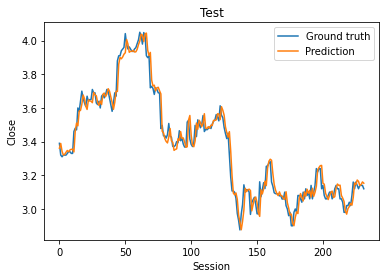

MSE: 0.00224923
MAPE: 0.01234285
RMSE: 0.05356770
R2: 0.98751885


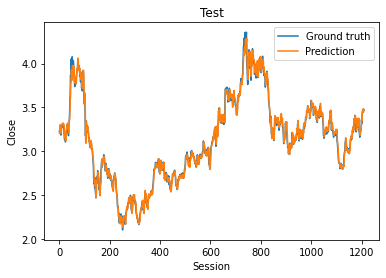

Models saved.
BOCOM
MLP(
  (l1): Linear(in_features=22, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=64, bias=True)
  (l3): Linear(in_features=64, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=1, bias=True)
)
epoch:   1
loss: 0.18097405
validation loss: 0.04482476
epoch: 100
loss: 0.00324988
validation loss: 0.00397216
epoch: 200
loss: 0.00261561
validation loss: 0.00366484
epoch: 300
loss: 0.00236164
validation loss: 0.00368018


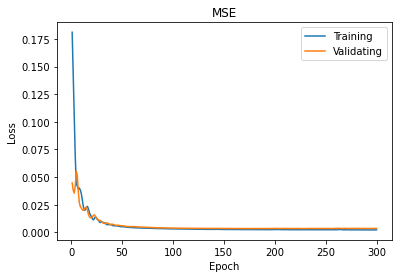

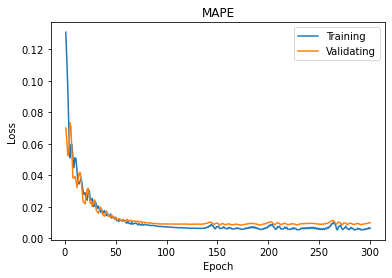

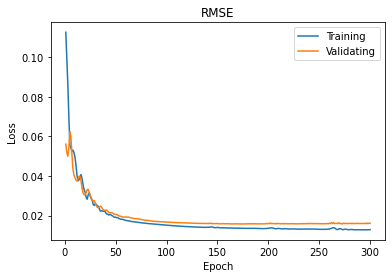

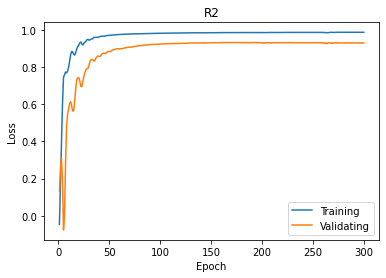

MSE: 0.00228764
MAPE: 0.01173987
RMSE: 0.01267476
R2: 0.98036242


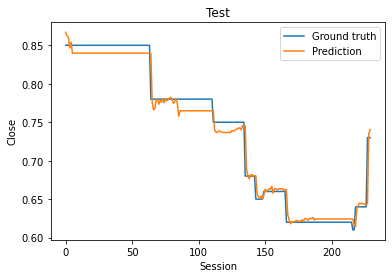

MSE: 0.00268355
MAPE: 0.01297848
RMSE: 0.01372779
R2: 0.98510873


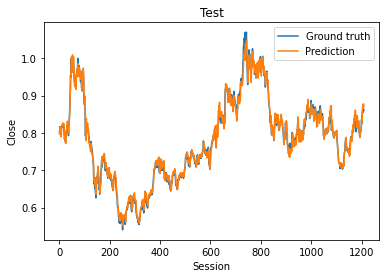

LSTM(
  (l1): LSTM(22, 128, batch_first=True)
  (l2): LSTM(128, 64, batch_first=True)
  (l3): Linear(in_features=64, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=1, bias=True)
)
epoch:   1
loss: 0.21594325
validation loss: 0.06517769
epoch: 100
loss: 0.00423751
validation loss: 0.00546562
epoch: 200
loss: 0.00289488
validation loss: 0.00350401
epoch: 300
loss: 0.00259602
validation loss: 0.00314710


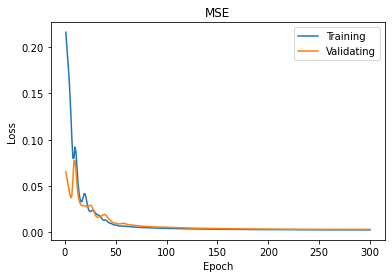

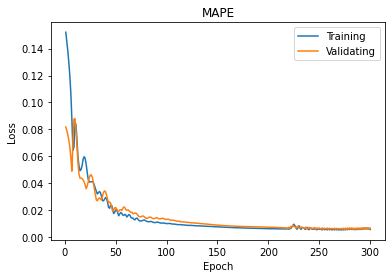

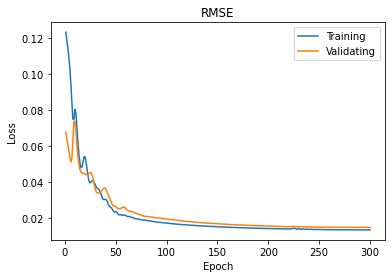

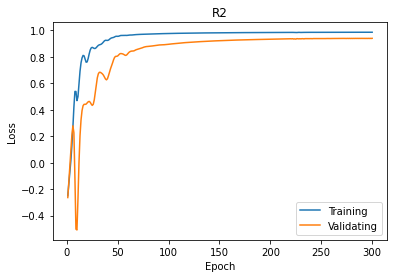

MSE: 0.00152954
MAPE: 0.00660822
RMSE: 0.01036396
R2: 0.98687017


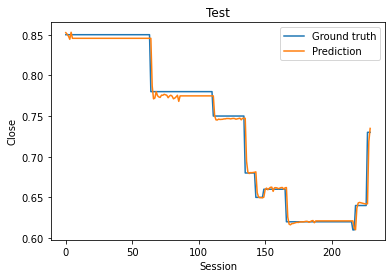

MSE: 0.00212589
MAPE: 0.01131675
RMSE: 0.01221846
R2: 0.98820323


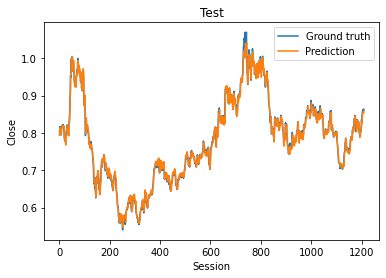

Models saved.
CCB
MLP(
  (l1): Linear(in_features=22, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=64, bias=True)
  (l3): Linear(in_features=64, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=1, bias=True)
)
epoch:   1
loss: 0.19405596
validation loss: 0.62723392
epoch: 100
loss: 0.00279176
validation loss: 0.00727936
epoch: 200
loss: 0.00212374
validation loss: 0.00529531
epoch: 300
loss: 0.00191729
validation loss: 0.00562820


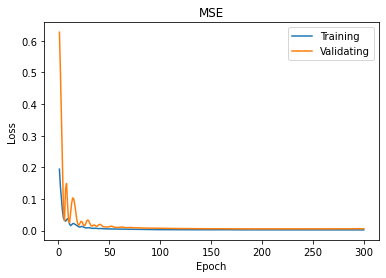

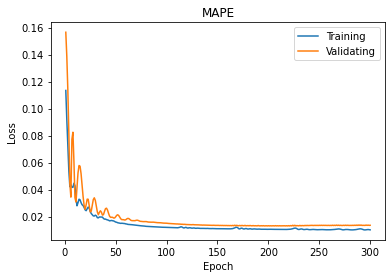

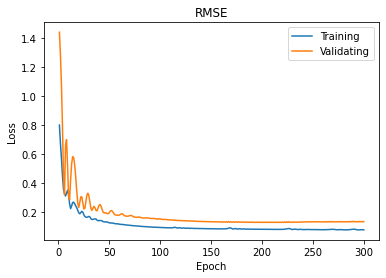

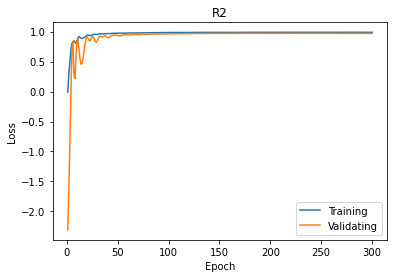

MSE: 0.00187646
MAPE: 0.00896288
RMSE: 0.07862233
R2: 0.96294671


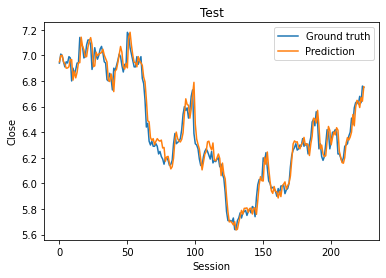

MSE: 0.00213089
MAPE: 0.01015343
RMSE: 0.08378331
R2: 0.98817545


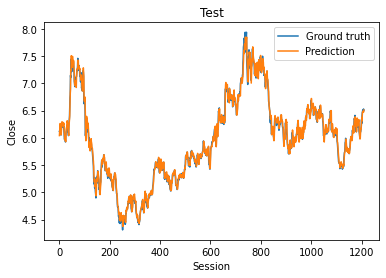

LSTM(
  (l1): LSTM(22, 128, batch_first=True)
  (l2): LSTM(128, 64, batch_first=True)
  (l3): Linear(in_features=64, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=1, bias=True)
)
epoch:   1
loss: 0.19917823
validation loss: 0.59540385
epoch: 100
loss: 0.00359120
validation loss: 0.01102086
epoch: 200
loss: 0.00246994
validation loss: 0.00846748
epoch: 300
loss: 0.00229723
validation loss: 0.00782964


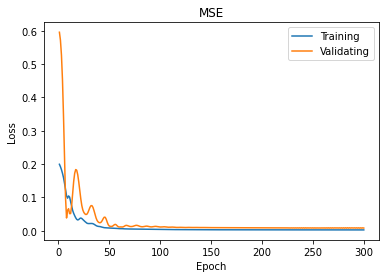

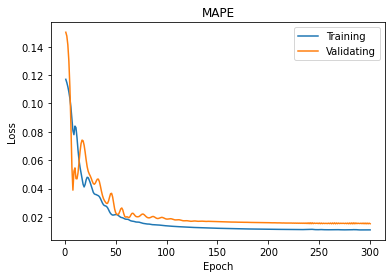

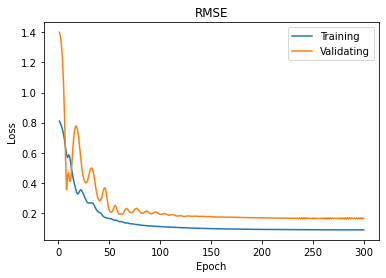

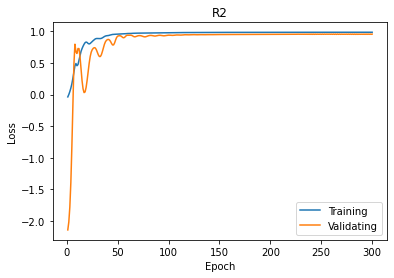

MSE: 0.00180191
MAPE: 0.00891532
RMSE: 0.07704473
R2: 0.96441877


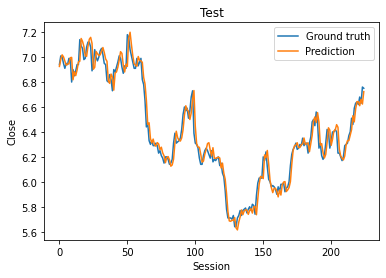

MSE: 0.00203446
MAPE: 0.00983411
RMSE: 0.08186553
R2: 0.98871058


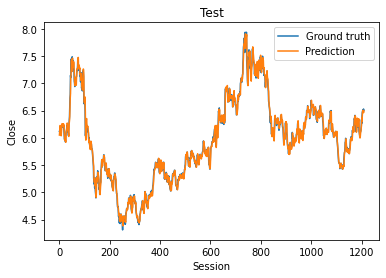

Models saved.
HSB
MLP(
  (l1): Linear(in_features=22, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=64, bias=True)
  (l3): Linear(in_features=64, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=1, bias=True)
)
epoch:   1
loss: 0.28593636
validation loss: 0.68500346
epoch: 100
loss: 0.00262210
validation loss: 0.01144697
epoch: 200
loss: 0.00188037
validation loss: 0.00863342
epoch: 300
loss: 0.00167355
validation loss: 0.00879298


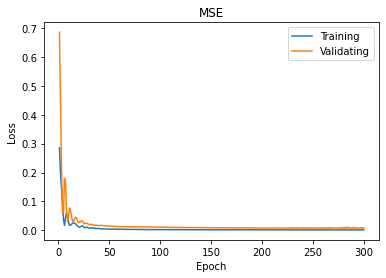

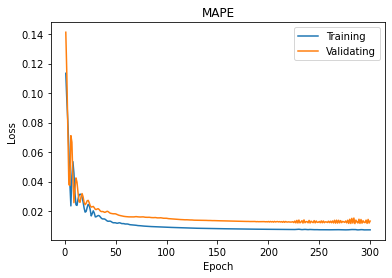

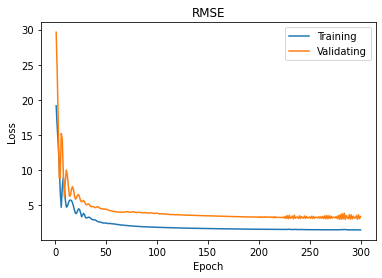

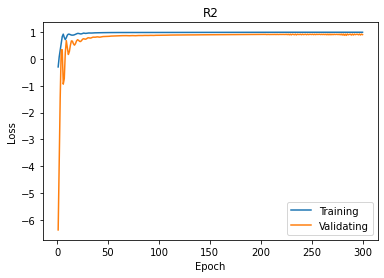

MSE: 0.00511419
MAPE: 0.01075960
RMSE: 2.56018472
R2: 0.97348303


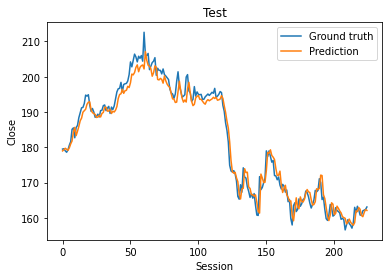

MSE: 0.00241461
MAPE: 0.00821262
RMSE: 1.75916576
R2: 0.98660111


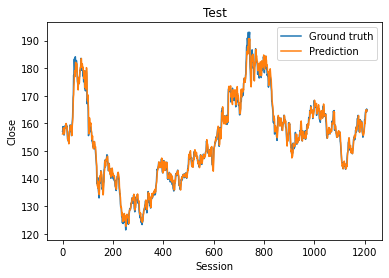

LSTM(
  (l1): LSTM(22, 128, batch_first=True)
  (l2): LSTM(128, 64, batch_first=True)
  (l3): Linear(in_features=64, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=1, bias=True)
)
epoch:   1
loss: 0.25247085
validation loss: 1.14780951
epoch: 100
loss: 0.00331279
validation loss: 0.03650742
epoch: 200
loss: 0.00211127
validation loss: 0.03562758
epoch: 300
loss: 0.00188909
validation loss: 0.03174349


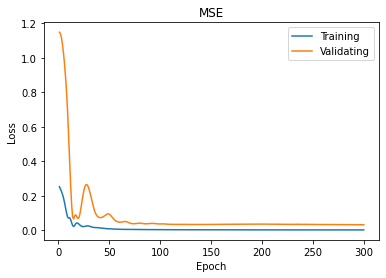

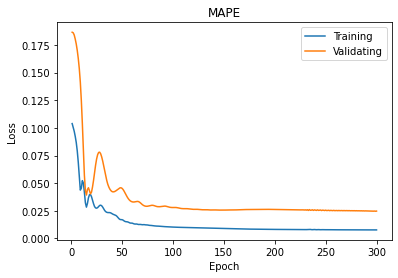

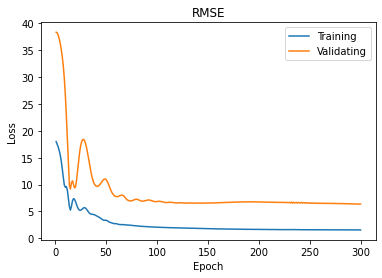

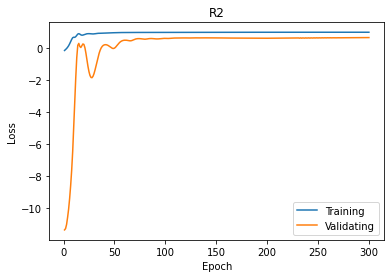

MSE: 0.01134803
MAPE: 0.01531321
RMSE: 3.81367230
R2: 0.94116056


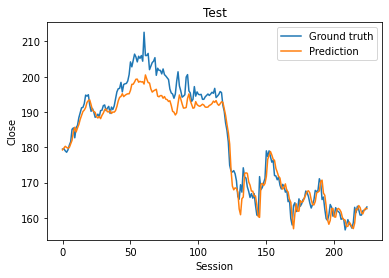

MSE: 0.00245123
MAPE: 0.00816119
RMSE: 1.77245510
R2: 0.98639786


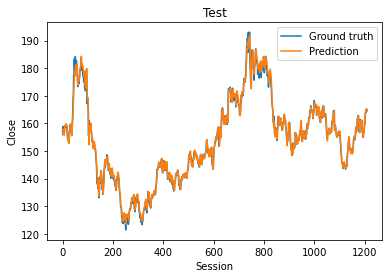

Models saved.
HSBC
MLP(
  (l1): Linear(in_features=22, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=64, bias=True)
  (l3): Linear(in_features=64, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=1, bias=True)
)
epoch:   1
loss: 0.30690300
validation loss: 0.37141600
epoch: 100
loss: 0.00283995
validation loss: 0.00308823
epoch: 200
loss: 0.00205867
validation loss: 0.00244154
epoch: 300
loss: 0.00202978
validation loss: 0.00283186


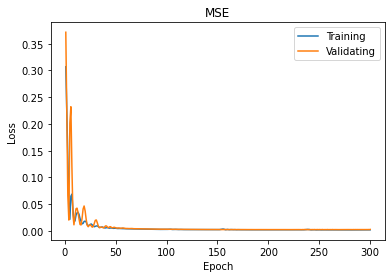

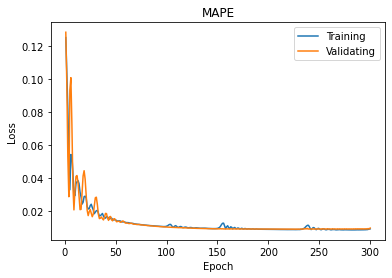

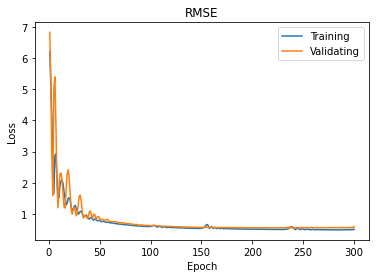

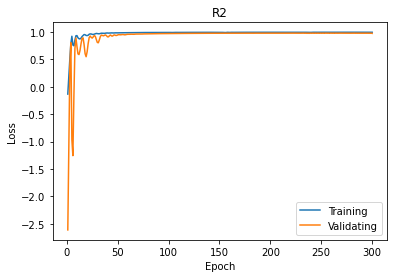

MSE: 0.00156805
MAPE: 0.00830011
RMSE: 0.44350404
R2: 0.96060258


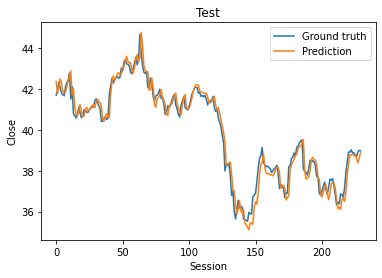

MSE: 0.00264818
MAPE: 0.01109516
RMSE: 0.57635725
R2: 0.98530501


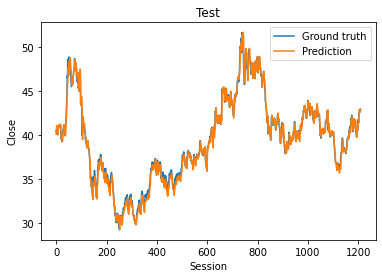

LSTM(
  (l1): LSTM(22, 128, batch_first=True)
  (l2): LSTM(128, 64, batch_first=True)
  (l3): Linear(in_features=64, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=1, bias=True)
)
epoch:   1
loss: 0.29220942
validation loss: 0.20771056
epoch: 100
loss: 0.00390608
validation loss: 0.00350972
epoch: 200
loss: 0.00238011
validation loss: 0.00238251
epoch: 300
loss: 0.00213439
validation loss: 0.00236082


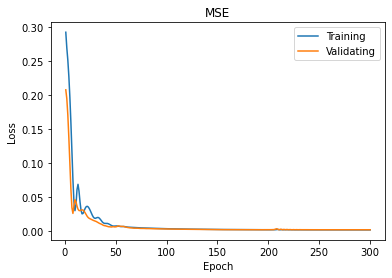

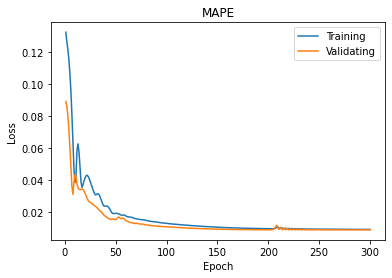

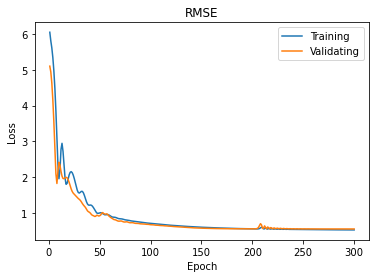

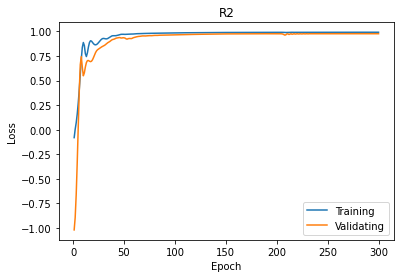

MSE: 0.00130913
MAPE: 0.00723223
RMSE: 0.40523753
R2: 0.96710783


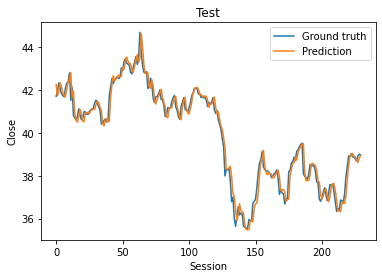

MSE: 0.00204973
MAPE: 0.00926172
RMSE: 0.50706810
R2: 0.98862588


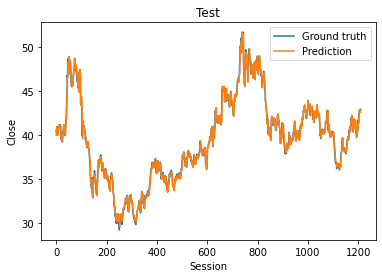

Models saved.
ICBC
MLP(
  (l1): Linear(in_features=22, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=64, bias=True)
  (l3): Linear(in_features=64, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=1, bias=True)
)
epoch:   1
loss: 0.29492387
validation loss: 0.19187886
epoch: 100
loss: 0.00298611
validation loss: 0.00496131
epoch: 200
loss: 0.00200771
validation loss: 0.00478890
epoch: 300
loss: 0.00185736
validation loss: 0.00549709


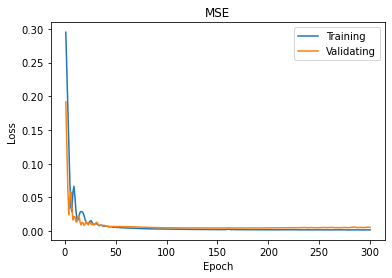

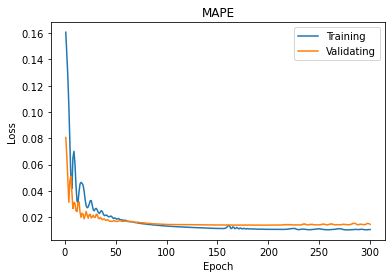

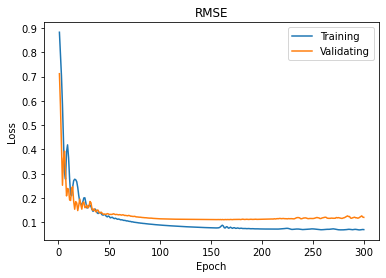

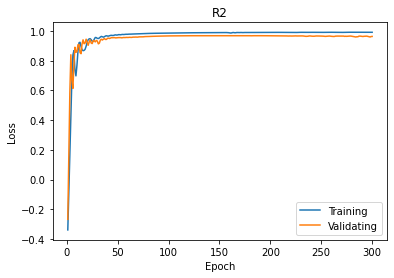

MSE: 0.00194717
MAPE: 0.00933501
RMSE: 0.07170585
R2: 0.95124841


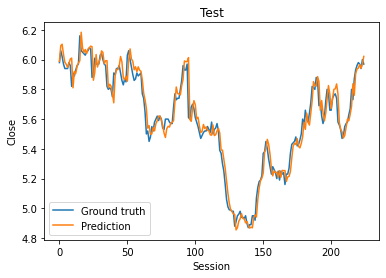

MSE: 0.00225380
MAPE: 0.01060448
RMSE: 0.07714557
R2: 0.98749346


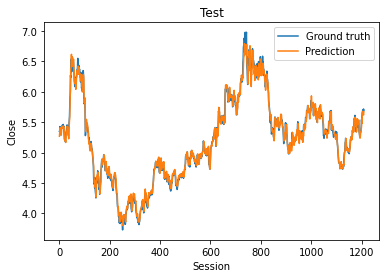

LSTM(
  (l1): LSTM(22, 128, batch_first=True)
  (l2): LSTM(128, 64, batch_first=True)
  (l3): Linear(in_features=64, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=1, bias=True)
)
epoch:   1
loss: 0.33968988
validation loss: 0.21600878
epoch: 100
loss: 0.00437984
validation loss: 0.00757010
epoch: 200
loss: 0.00249365
validation loss: 0.00441551
epoch: 300
loss: 0.00218195
validation loss: 0.00422760


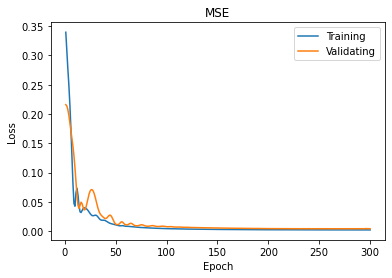

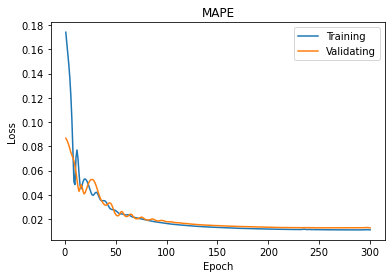

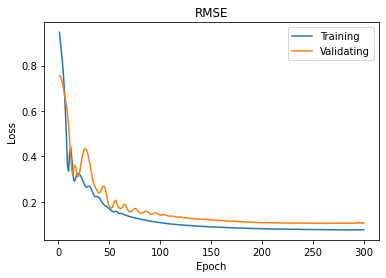

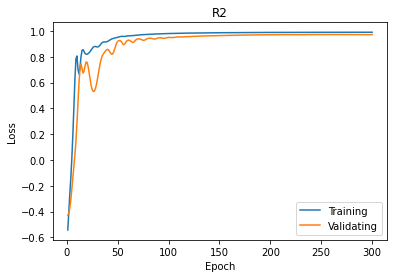

MSE: 0.00192203
MAPE: 0.00925380
RMSE: 0.07124161
R2: 0.95187759


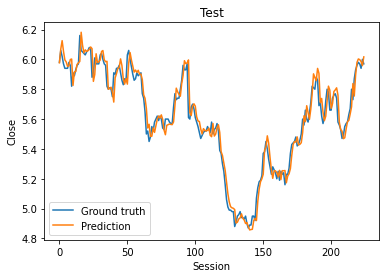

MSE: 0.00203825
MAPE: 0.01012506
RMSE: 0.07336392
R2: 0.98868954


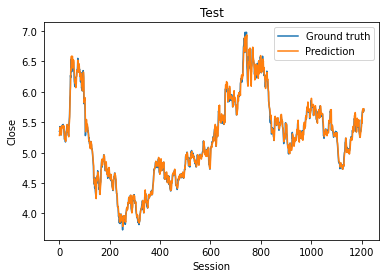

Models saved.


In [21]:
# For each dataset, build an MLP and an LSTM model
for corp, df in data.items():
    print(corp)
    
    net1, results1 = build_and_train(df, l, p, MLP, criterion, epochs, X, Y, device)
    torch.save(net1.state_dict(), "Models/" +  corp + "_MLP.pth")
    mlp_results[corp] = results1
    
    net2, results2 = build_and_train(df, l, p, LSTM, criterion, epochs, X, Y, device)
    torch.save(net2.state_dict(), "Models/" +  corp + "_LSTM.pth")
    lstm_results[corp] = results2
    
    print("Models saved.")

Save results

In [22]:
mlp_pretrained = pd.DataFrame.from_dict(mlp_results, orient='index', columns=['MSE', 'MAPE', 'RMSE', 'R2'])
mlp_pretrained.to_csv("Results/mlp_pretrained.csv")

mlp_pretrained

,MSE,MAPE,RMSE,R2
BOC,0.002695,0.012662,0.070343,0.985045
BOCHK,0.002770,0.013610,0.059450,0.984627
BOCOM,0.002684,0.012978,0.013728,0.985109
CCB,0.002131,0.010153,0.083783,0.988175
HSB,0.002415,0.008213,1.759166,0.986601
HSBC,0.002648,0.011095,0.576357,0.985305
ICBC,0.002254,0.010604,0.077146,0.987493


In [23]:
lstm_pretrained = pd.DataFrame.from_dict(lstm_results, orient='index', columns=['MSE', 'MAPE', 'RMSE', 'R2'])
lstm_pretrained.to_csv("Results/lstm_pretrained.csv")

lstm_pretrained

,MSE,MAPE,RMSE,R2
BOC,0.002538,0.012229,0.068264,0.985916
BOCHK,0.002249,0.012343,0.053568,0.987519
BOCOM,0.002126,0.011317,0.012218,0.988203
CCB,0.002034,0.009834,0.081866,0.988711
HSB,0.002451,0.008161,1.772455,0.986398
HSBC,0.002050,0.009262,0.507068,0.988626
ICBC,0.002038,0.010125,0.073364,0.988690
